In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

%cd /content/drive/MyDrive/Colab\ Notebooks/GitHub/

# Set current working project repo
repository = 'AmazonReview_UsefulnessRanker'
%cd {repository}

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/GitHub
/content/drive/MyDrive/Colab Notebooks/GitHub/AmazonReview_UsefulnessRanker


# Data Challenge Presentation

## Agenda
- [Problem Statement](#problem-statement)
- [Project Structure](#project-structure)
  - [Pre-processing](#pre-processing)
  - [Embedding Step](#embedding-step)
  - [Modelling](#modelling)
    - [Logistic Regression](#logistic-regression)
      - [Metric Choice](#metric-choice)
      - [Evaluation Process](#evaluation-process)
      - [Hyperparameter Tuning](#hyperparameter-tuning)
    - [XGBoost](#xgboost)
      - [Model Choice](#model-choice)
      - [Evaluation Process](#evaluation-process-1)
      - [Metric Selection](#metric-selection)
- [Conclusion](#conclusion)
- [Brainstorming/Improvements](#brainstorming)

## Problem Statement
<a id="problem-statement"></a>

### Pre-processing Steps
- **Steps**:

### Imbalance Target: Sampling Techniques
<a id="imbalance-target"></a>
- **Steps**:

### Embedding Step
<a id="embedding-step"></a>
- **Steps**:

### Modelling
<a id="modelling"></a>

#### Logistic Regression
<a id="logistic-regression"></a>
##### Metric Choice
<a id="metric-choice"></a>
- **Steps**:

##### Evaluation Process
<a id="evaluation-process"></a>
- **Steps**:

#### XGBoost
<a id="xgboost"></a>
##### Model Choice
<a id="model-choice"></a>
- **Steps**:

##### Evaluation Process
<a id="evaluation-process"></a>
- **Steps**:

##### Metric Selection
<a id="metric-selection"></a>
- **Steps**:

##### Hyperparameter Tuning
<a id="hyperparameter-tuning"></a>
- **Steps**:

## Conclusion
<a id="conclusion"></a>

## Prompt Optimization
<a id="prompt-optimization"></a>



#**Problem Statement:**

## Overview

## Instructions
The Amazon Book Reviews Dataset is a collection of customer reviews for books sold on Amazon. This dataset is part of the broader Amazon Customer Reviews Dataset, which includes reviews for a variety of product categories.The Book dataset offers insights into customer opinions, ratings, and experiences with books, making it a valuable resource for research in natural language processing (NLP), sentiment analysis, and recommendation systems.

## Data:
* Download the Amazon Book Reviews Dataset from [Kaggle](https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset?select=amazon_reviews_us_Books_v1_02.tsv).
* Note: you do not need to download the full dataset - just the books subset:
* Filter the dataset for the last two years of reviews available (2003-2005).

### Data Dictionary:
* **marketplace:** A two-letter country code representing the marketplace where the review was written.
* **customer_id:** A random identifier for the customer.
* **review_id:** The unique identifier for each review.
* **product_id:** The unique identifier for the product being reviewed.
* **product_parent:** A random identifier that can be used to aggregate reviews for the same product.
* **product_title:** The title of the product.
* **product_category:** The broad category under which the product falls.
* **star_rating:** The star rating given by the reviewer, ranging from 1 to 5 stars.
* **helpful_votes:** The number of votes indicating how many customers found
the review helpful.
* **total_votes:** The total number of votes the review received.
* **vine:** Indicates whether the review was written as part of the Vine program, where selected reviewers receive free products for review.
* **verified_purchase:** Indicates whether the review is based on a verified purchase.
* **review_headline:** The title or headline of the review.
* **review_body:** The main text of the review.
* **review_date:** The date on which the review was written.

## Background to Task
* You are responsible for optimising the display of information on an e-commerce website selling books.
* This website contains descriptions of books and a section on each book page for users to leave reviews of books they have previously read. You have been asked to create a model that will optimise the display of reviews so that reviews which are most likely to be helpful are surfaced first to users while reviews that are less likely to be helpful are less likely to be displayed.

## Outline of Objectives
* Carry out EDA of the dataset and report on your findings - this may be inline in a notebook based tool

* Create a model that predicts the likelihood of a review being helpful (you may, for example, take the ‘helpfulness’ as the ratio of helpful_votes to total_votes)

* Evaluate this model and report on your findings

In [56]:
# import tensorflow as tf
# print("GPU Available:", tf.config.list_physical_devices('GPU'))

In [57]:
# !pip install sentence-transformers
# from sentence_transformers import SentenceTransformer
# !pip install joblib

In [58]:
# import nltk

# Download necessary NLTK datasets
# nltk.download('stopwords')
# nltk.download('wordnet')

In [14]:
# Import libraries

import re
import time
import zipfile
import pandas as pd
import numpy as np
from tqdm import tqdm

# import torch
# from torch.cuda.amp import autocast

from tqdm import tqdm
from multiprocessing import Pool, cpu_count

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data files
# nltk.download('stopwords')
# nltk.download('wordnet')

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download necessary NLTK data files
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

from multiprocessing import Pool, cpu_count
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import Ridge
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

from imblearn.pipeline import Pipeline

import joblib
from joblib import dump, load

import gc
import pickle
import scipy.sparse
from scipy.sparse import vstack

import warnings

# Suppress all warnings

## Load Data

In [60]:
# setting random seed
seed = 42
np.random.seed(seed)

In [61]:
# loading data

# Specify the path to your zip file
# zip_file_path = r"/content/drive/MyDrive/Colab Notebooks/GitHub/AmazonReview_UsefulnessRanker/data/amazon_reviews_us_Books_v1_02.tsv.zip"

# Use pandas to read the data directly from the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as z:
    # Assuming the zip file contains a single TSV file named amazon_reviews_us_Books_v1_02.tsv
#     with z.open('amazon_reviews_us_Books_v1_02.tsv') as f:
        # Read the TSV file directly from the zip archive
#         df = pd.read_csv(f, sep='\t', on_bad_lines="skip")

# Display the first few rows of the DataFrame
#df.head()


In [62]:
# Convert 'review_date' to datetime format if it's in string format
# df['review_date'] = pd.to_datetime(df['review_date'])

# Define the start and end dates for your filter (2003-01-01 to 2005-12-31)
# start_date = pd.to_datetime('2003-01-01')
# end_date = pd.to_datetime('2005-12-31')

# Apply the filter to select rows within the date range
# book_df = df.loc[(df['review_date'] >= start_date) & (df['review_date'] <= end_date), :].copy()

# Optionally, you can reset the index if needed
# book_df.reset_index(drop=True, inplace=True)

# Save filtered data into csv

# Save the filtered DataFrame to a CSV file
# book_df.to_parquet('data/filtered_amazon_reviews.parquet', index=False)

In [63]:
# Loading filtered data

file_path = r"/content/drive/MyDrive/Colab Notebooks/GitHub/AmazonReview_UsefulnessRanker/data/filtered_amazon_reviews.parquet"
#kaggle_file_path = '/kaggle/input/amazonreview-usefulnessdata/filtered_amazon_reviews.parquet'
book_df = pd.read_parquet(file_path)

KeyboardInterrupt: 

In [ ]:
print(book_df.shape)
book_df.head()

In [ ]:
# Look at shape of data
book_df.info()

## Data Preprocessing

### Target Variable Creation

In [ ]:
# Missing value Treatment
book_df.isnull().sum()

In [ ]:
book_df.review_headline.fillna('', inplace=True)

In [ ]:
# Check for NaN values
print("Checking for NaN values:")
print(book_df.isnull().sum())

In [ ]:
# Check for NaN values
print("Checking for NaN values in helpful_votes and total_votes:")
print(book_df[['helpful_votes', 'total_votes']].isnull().sum())


In [ ]:
# Ensure total_votes is not zero to avoid division by zero
book_df[book_df['total_votes'] < 0].sum()

In [ ]:
# Ensure total_votes is not zero to avoid division by zero
book_df[book_df['helpful_votes'] < 0].sum()

In [ ]:
print("Checking for zero values in total_votes:")
print((book_df['total_votes'] == 0).sum())


In [ ]:
# Ensure total_votes is not zero to avoid division by zero
# Create a copy to avoid setting on a slice
book_df = book_df[book_df['total_votes'] > 0].copy()

# Calculate helpfulness ratio
book_df['helpfulness_ratio'] = book_df['helpful_votes'] / book_df['total_votes']

In [ ]:
# Check for NaN values
print("Checking for NaN values:")
print(book_df.isnull().sum())

In [ ]:
# Compute descriptive statistics
stats = book_df['helpfulness_ratio'].describe()

# Format the statistics
formatted_stats = stats.apply(lambda x: round(x, 3))  # Round to 3 decimal places

# Print formatted statistics
print("Descriptive Statistics of Helpfulness Ratio:")
print(formatted_stats)

# Kernel Density Plot
plt.figure(figsize=(6, 5))
sns.kdeplot(book_df['helpfulness_ratio'], fill=True, color='blue')
plt.title('Density Plot of Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Density')
plt.show()

In [ ]:
# Check for NaN values
print("Checking for NaN values:")
print(book_df.isnull().sum())

In [ ]:
# Apply log transformation (log1p) to handle skewness
book_df['log_helpfulness_ratio'] = np.log1p(book_df['helpfulness_ratio'])

# Drop the original helpfulness_ratio column
book_df.drop(columns=['helpfulness_ratio'], inplace=True)

# Compute descriptive statistics
stats = book_df['log_helpfulness_ratio'].describe()

# Kernel Density Plot of log_helpfulness_ratio
plt.figure(figsize=(6, 5))
sns.kdeplot(book_df['log_helpfulness_ratio'], fill=True, color='blue')
plt.title('Density Plot of Log-Transformed Helpfulness Ratio')
plt.xlabel('Log-Transformed Helpfulness Ratio')
plt.ylabel('Density')
plt.show()

# Compute descriptive statistics
stats = book_df['log_helpfulness_ratio'].describe()

# Format the statistics
formatted_stats = stats.apply(lambda x: round(x, 3))  # Round to 3 decimal places

# Print formatted statistics
print("Descriptive Statistics of Helpfulness Ratio:")
print(formatted_stats)

In [ ]:
book_df.isnull().sum()

**Observation:**


*   **Target Variable:**
  * **Current:** Noticed slight right-skewness in the distribution of helpfulness ratio. Which implies higher helpfulness ratios than lower ones, but this is expected considering the nature of how users see only few reviews.
  * **Proposed:** Applying log transformation to reduce the skewness slightly   



Anchor: point of normalizing votes?

Or clean data first and then truncate which sounds like good order

Combine headline and body
decide whether to truncate first and then combine

In [ ]:
# Check Unique values
book_df.nunique()

In [ ]:
book_df.head()

### EDA

In [ ]:
# General function to generate histogram
def count_plot(attribute, label):
    plt.figure(figsize=(6, 5))
    sns.countplot(data=book_df, x=attribute)
    plt.xlabel(label)
    plt.ylabel('Count')
    plt.title(f'Distribution of {label}')
    plt.show()

count_plot('star_rating', 'Star Ratings')

In [ ]:
# Count plot of verified purchases
count_plot('verified_purchase', 'Verified Purchase')

In [ ]:
# Scatter plot of star rating vs helpful votes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='star_rating', y='helpful_votes', data=book_df, alpha=0.5)
plt.title('Relationship Between Star Rating and Helpful Votes')
plt.xlabel('Star Rating')
plt.ylabel('Helpful Votes')
plt.show()

In [ ]:
# List of columns to exclude from correlation calculation
non_numeric_columns = ['marketplace', 'review_id', 'product_id', 'product_title',
                       'product_category', 'vine', 'verified_purchase', 'review_headline']

# Select only numeric columns
numeric_columns = book_df.select_dtypes(include=['number']).columns.tolist()

# Exclude non-numeric columns
numeric_columns = [col for col in numeric_columns if col not in non_numeric_columns]

# Compute correlation matrix for numeric columns only
numeric_corr_matrix = book_df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap for Numeric Features')
plt.show()


In [ ]:
# drop columns
cols_drop = ['marketplace', 'customer_id', 'review_id', 'product_category',
             'vine', 'helpful_votes', 'total_votes']
book_df = book_df.drop(cols_drop, axis=1).reset_index()

In [ ]:
book_df.head()

**Anchor:**
- Atleast 3 helpful votes - deicide to use or no ;removes spam messages

**Anchor Observation:**
  *   Usefulness already records the product level because this is a ratio of total votes at product level, using just review column

*   **In conclusion:** Ranking at the end at each product level

### Truncate reviews

In [ ]:
# Extract metadata columns
metadata_df = book_df[['product_id', 'product_parent', 'product_title', 'star_rating', 'verified_purchase', 'review_date']].copy()

# Extract columns for analysis
review_df = book_df[['product_id', 'review_headline', 'review_body', 'log_helpfulness_ratio']].copy()

# Optionally, reset the index for both DataFrames if needed
metadata_df.reset_index(drop=True, inplace=True)
review_df.reset_index(drop=True, inplace=True)

# Display first few rows of each DataFrame to verify
# print("Metadata DataFrame:")
# print(metadata_df.head())

# print("\n DataFrame:")
# print(review_df.head())

del book_df
# del metadata_df

In [ ]:
review_df.isnull().sum()

In [ ]:
# Function to calculate number of words
def count_words(text):
    return len(text.split())

def count_matplot(df, column_name, bins):
  # Calculate histogram
    counts, bin_edges = np.histogram(df[column_name], bins=bins)

    # Print the counts and corresponding bin edges
    for i in range(len(counts)):
        print(f'Bin range: {bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}, Count: {counts[i]}')

    # Plot the histogram
    plt.figure(figsize=(6, 5))
    plt.hist(df[column_name], bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of Word Counts in {column_name}')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [ ]:
# Add new column for word count
review_df['word_count_headline'] = review_df['review_headline'].apply(count_words)

count_matplot(review_df, 'word_count_headline', 30)

In [ ]:
# Add new column for word count
review_df['word_count_body'] = review_df['review_body'].apply(count_words)

count_matplot(review_df, 'word_count_body', 50)

In [ ]:
# Truncate review body to 1200
review_df = review_df[review_df.word_count_body <1200].reset_index()

# Print basic statistics for word counts
word_count_stats = review_df['word_count_body'].describe()
print(word_count_stats)

In [ ]:
# Check for NaN values
print("Checking for NaN values:")
print(review_df.isnull().sum())

**Observation:**
* Anchor:
  *  Based on the observation, performing initial trunc at 1200 and testing

### Tokenization & Cleaning

In [ ]:
def convert_to_lowercase(text):
    return text.lower()

# start_time = time.time()
# review_df['review_headline'] = review_df['review_headline'].apply(convert_to_lowercase)
# review_df['review_body'] = review_df['review_body'].apply(convert_to_lowercase)
# print("Time to convert to lowercase: {:.2f} seconds".format(time.time() - start_time))

def remove_html_tags(text):
    return re.sub(r'<[^>]*>', '', text)

# start_time = time.time()
# review_df['review_headline'] = review_df['review_headline'].apply(remove_html_tags)
# review_df['review_body'] = review_df['review_body'].apply(remove_html_tags)
# print("Time to remove HTML tags: {:.2f} seconds".format(time.time() - start_time))

def remove_unwanted_chars(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

# start_time = time.time()
# review_df['review_headline'] = review_df['review_headline'].apply(remove_unwanted_chars)
# review_df['review_body'] = review_df['review_body'].apply(remove_unwanted_chars)
# print("Time to remove unwanted characters: {:.2f} seconds".format(time.time() - start_time))

def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# start_time = time.time()
# review_df['review_headline'] = review_df['review_headline'].apply(remove_urls)
# review_df['review_body'] = review_df['review_body'].apply(remove_urls)
# print("Time to remove URLs: {:.2f} seconds".format(time.time() - start_time))

def remove_email_addresses(text):
    return re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

# start_time = time.time()
# review_df['review_headline'] = review_df['review_headline'].apply(remove_email_addresses)
# review_df['review_body'] = review_df['review_body'].apply(remove_email_addresses)
# print("Time to remove email addresses: {:.2f} seconds".format(time.time() - start_time))

# stop_words = set(stopwords.words('english'))

# start_time = time.time()

# Tokenize all reviews once
# tokenized_reviews = [word_tokenize(text) for text in review_df['review_headline']]

# Remove stop words
# reviews_no_stopwords = [[word for word in tokens if word.lower() not in stop_words] for tokens in tokenized_reviews]

# Join words back into sentences (if needed)
# cleaned_reviews = [' '.join(tokens) for tokens in reviews_no_stopwords]

# Replace original column with cleaned text
# review_df['review_headline'] = cleaned_reviews
# print("Time to tokenize and remove stopwords: {:.2f} seconds".format(time.time() - start_time))

def remove_stopwords(text):
    return ' '.join([word for word in word_tokenize(text) if word.lower() not in stop_words])

def apply_parallel(df):
    with Pool(cpu_count()) as pool:
        return list(tqdm(pool.imap(remove_stopwords, df), total=len(df)))

# start_time = time.time()
# Apply in parallel
# review_df['review_body'] = apply_parallel(review_df['review_body'])
# print("Time to tokenize and remove stopwords: {:.2f} seconds".format(time.time() - start_time))

# Initialize WordNetLemmatizer outside of the function for better multiprocessing performance
# lemmatizer = WordNetLemmatizer()

# Function to get WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # adjective
    elif tag.startswith('V'):
        return 'v'  # verb
    elif tag.startswith('N'):
        return 'n'  # noun
    elif tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # default to noun for lemmatization

# Function to lemmatize text with POS tagging
def lemmatize_with_pos_tagging(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return ' '.join(lemmatized_words)

# Apply in parallel using multiprocessing
def apply_parallel(df_column):
    with Pool(cpu_count()) as pool:
        return list(tqdm(pool.imap(lemmatize_with_pos_tagging, df_column), total=len(df_column)))

# Applying lemmatization
# if __name__ == '__main__':

#    start_time = time.time()
#    review_df['review_headline'] = apply_parallel(review_df['review_headline'])
#    review_df['review_body'] = apply_parallel(review_df['review_body'])
#    print("Time to lemmatize with POS tagging using multiprocessing: {:.2f} seconds".format(time.time() - start_time))
#    print(review_df.head())  # Print the updated DataFrame to verify results

# Save review results to file
# review_df.to_parquet('data/review_df_cleaned.parquet', index=False)

In [ ]:
# Loading cleaned review data

cleaned_file_path = r"/content/drive/MyDrive/Colab Notebooks/GitHub/AmazonReview_UsefulnessRanker/data/review_df_cleaned.parquet"
# kagg_cleaned_file_path = "/kaggle/input/amazonreview-usefulnessdata/review_df_cleaned.parquet"
review_df = pd.read_parquet(cleaned_file_path)

# review_df = review_df.drop(['level_0', 'index', 'word_count_headline', 'word_count_body'], axis=1)

# review_df = review_df.reset_index()

In [ ]:
# Fixing missed nans, Drop rows with NaN values in log_helpfulness_ratio
review_df.dropna(subset=['log_helpfulness_ratio'], inplace=True)

# Optional: Verify that the rows have been dropped
print("Checking for NaN values after dropping:")
print(review_df.isnull().sum())


In [ ]:
# Add new column for word count
review_df['word_count_headline'] = review_df['review_headline'].apply(count_words)

# Add new column for word count
review_df['word_count_body'] = review_df['review_body'].apply(count_words)

In [ ]:
count_matplot(review_df, 'word_count_headline', 15)

In [ ]:
count_matplot(review_df, 'word_count_body', 50)

In [ ]:
#
review_df.describe().T

In [ ]:
def truncate_and_clean(df, combined_cutoff=300, lower_cutoff=20):

    # Combine headline and body
    df['review_text'] = df['review_headline'] + ' ' + df['review_body']

    # Define the truncation function
    def truncate_text(text, cutoff):
        words = text.split()
        return ' '.join(words[:cutoff])

    # Apply truncation
    df['review_text'] = df['review_text'].apply(lambda x: truncate_text(x, combined_cutoff))

    # Filter out texts that are too short after cleaning
    df = df[df['review_text'].apply(lambda x: len(x.split()) >= lower_cutoff)]

    # Recalculate word counts after cleaning
    df['word_count_combined'] = df['review_text'].apply(lambda x: len(x.split()))

    return df

# Apply truncation, cleaning, and filtering
review_df = truncate_and_clean(review_df, combined_cutoff=250, lower_cutoff=20)

# Visualize the results
count_matplot(review_df, 'word_count_combined', 50)

In [ ]:
review_df = review_df[['product_id', 'review_text', 'log_helpfulness_ratio']].copy()

# Save review results to file
# review_df.to_parquet('data/review_df_final2.parquet', index=False)

In [5]:
# Loading cleaned review data

final_file_path = r"/content/drive/MyDrive/Colab Notebooks/GitHub/AmazonReview_UsefulnessRanker/data/review_df_final2.parquet"
# kagg_final_file_path = "/kaggle/input/amazonreview-usefulnessdata/review_df_final.parquet"
review_df = pd.read_parquet(final_file_path)

# Reset the index
review_df.reset_index(drop=True, inplace=True)

In [6]:
# Check for NaN values
print("Checking for NaN values:")
print(review_df.isnull().sum())

Checking for NaN values:
product_id               0
review_text              0
log_helpfulness_ratio    0
dtype: int64


**Achor observation:**

**Anchor EDA:** word cloud

### Train Test Split

In [7]:
X = review_df['review_text']
y = review_df['log_helpfulness_ratio'].rename({'log_helpfulness_ratio': 'target'})

# Initial split into train and validate
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Secondary split train into new train and test
# X_train_new, X_test, y_train_new, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [8]:
X_train = X_train.tolist()
X_val = X_val.tolist()

### Embeddings

In [9]:
# Load your model
# model = SentenceTransformer('paraphrase-mpnet-base-v2').to('cuda')

def encode_texts(texts, model, batch_size=1024):  # Increase batch size if possible
    embeddings = []
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient tracking
        for start in tqdm(range(0, len(texts), batch_size)):
            end = min(start + batch_size, len(texts))
            with autocast():  # Use mixed precision
                batch_embeddings = model.encode(
                    texts[start:end],
                    show_progress_bar=True,
                    device='cuda',
                    convert_to_tensor=True
                )
                embeddings.append(batch_embeddings)

    return torch.cat(embeddings).cpu().numpy()  # Concatenate and convert to numpy

# Generate embeddings for training and validation sets
# X_train_embeddings = encode_texts(X_train, model)
# np.save('train_embs.npy', X_train_embeddings)

# X_val_embeddings = encode_texts(X_val, model)
# np.save('val_embs.npy', X_val_embeddings)

In [10]:
def fit_vectorizer():
  vectorizer = TfidfVectorizer(max_features=5000)

  # Fit the vectorizer on the entire training set
  vectorizer.fit(X_train)

  # Save the vectorizer
  with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

  return vectorizer

def transform_in_batches(data, vectorizer, batch_size=1024):
    embeddings = []
    for start in tqdm(range(0, len(data), batch_size), desc="Batches Processed"):
        end = min(start + batch_size, len(data))
        batch_embeddings = vectorizer.transform(data[start:end])
        embeddings.append(batch_embeddings)
        del batch_embeddings
        gc.collect()
    return vstack(embeddings)

# vectorizer = fit_vectorizer()

# Transform the training and validation sets in batches
# X_train_tfidf = transform_in_batches(X_train, vectorizer)
# scipy.sparse.save_npz('train_embs_tfidf.npz', X_train_tfidf)

# X_val_tfidf = transform_in_batches(X_val, vectorizer)
# scipy.sparse.save_npz('val_embs_tfidf.npz', X_val_tfidf)

In [11]:
# Load the vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as f:
  vectorizer = pickle.load(f)

# Load the sparse matrices from disk & converting to dense matrix
X_train_embs = scipy.sparse.load_npz('train_embs_tfidf.npz')
X_val_embs = scipy.sparse.load_npz('val_embs_tfidf.npz')

# Ensure embeddings have consistent shapes
print(f"Training embeddings shape: {X_train_embs.shape}")
print(f"Validation embeddings shape: {X_val_embs.shape}")

print(f"Training targets shape: {y_train.shape}")
print(f"Validation targets shape: {y_val.shape}")

Training embeddings shape: (872200, 5000)
Validation embeddings shape: (218051, 5000)
Training targets shape: (872200,)
Validation targets shape: (218051,)


Anchor:
- Try glove or word2vec embeddings
- decide if converting to dense matrix is needed, tree based models can handle sparse matricces

## Modelling

**Ridge Model with CV**

In [18]:
# Using Ridge
# ridge_model = Ridge(alpha=1.0)
# Fitting the model on train
# ridge_model.fit(X_train_embs, y_train)
# Save the models and CV scores
# joblib.dump(ridge_model, 'ridge_model.pkl')

# Load the models
ridge_model = joblib.load('ridge_model.pkl')

# Perform 5-fold cross-validation
# ridge_cv_scores = cross_val_score(ridge_model, X_train_embs, y_train, cv=5, scoring='neg_root_mean_squared_error')
# joblib.dump(ridge_cv_scores, 'ridge_cv_scores.pkl')

# Load CV scores
ridge_cv_scores = joblib.load('ridge_cv_scores.pkl')

# Convert negative RMSE to positive
cv_rmse = -ridge_cv_scores

print(f"Cross-Validated RMSE: {cv_rmse}")
print(f"Mean RMSE: {cv_rmse.mean()}")
print(f"Standard Deviation of RMSE: {cv_rmse.std()}")

# Evalaution on unseen data
ridge_predictions = ridge_model.predict(X_val_embs)
print(f"Ridge Regression Validation RMSE: {mean_squared_error(y_val, ridge_predictions, squared=False)}")


Cross-Validated RMSE: [0.16661193 0.16643379 0.1657885  0.16655943 0.16704171]
Mean RMSE: 0.16648707246022926
Standard Deviation of RMSE: 0.0004047936044035386
Ridge Regression Validation RMSE: 0.16618774818188592


anchor: why ridge and not any other models?
- visualize learning rate curves + hyperparameter tuning

**Observation:**

**XGB Model:**

In [21]:
# Using XGBoost
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
# Fitting the model on train and save
# xgb_model.fit(X_train_embs, y_train)
# joblib.dump(xgb_model, 'xgb_model.pkl')

# Load model
xgb_model = joblib.load('xgb_model.pkl')

# Perform 5-fold cross-validation
# xgb_cv_scores = cross_val_score(xgb_model, X_train_embs, y_train, cv=5, scoring='neg_root_mean_squared_error')
# joblib.dump(xgb_cv_scores, 'xgb_cv_scores.pkl')

xgb_cv_scores = joblib.load('xgb_cv_scores.pkl')

# Convert negative RMSE to positive
cv_rmse = -xgb_cv_scores

print(f"Cross-Validated RMSE: {cv_rmse}")
print(f"Mean RMSE: {cv_rmse.mean()}")
print(f"Standard Deviation of RMSE: {cv_rmse.std()}")

# Evalaution on unseen data
xgb_predictions = xgb_model.predict(X_val_embs)
print(f"XGBoost Validation RMSE: {mean_squared_error(y_val, xgb_predictions, squared=False)}")


Cross-Validated RMSE: [0.16883714 0.16869307 0.16806594 0.16873446 0.16926258]
Mean RMSE: 0.16871863783060065
Standard Deviation of RMSE: 0.0003838821095441486
XGBoost Validation RMSE: 0.16841230742698776


Anchor, check for overfitting
Visualize in table results

Anchor: Additional metrics R2
Hyperparameter tuning

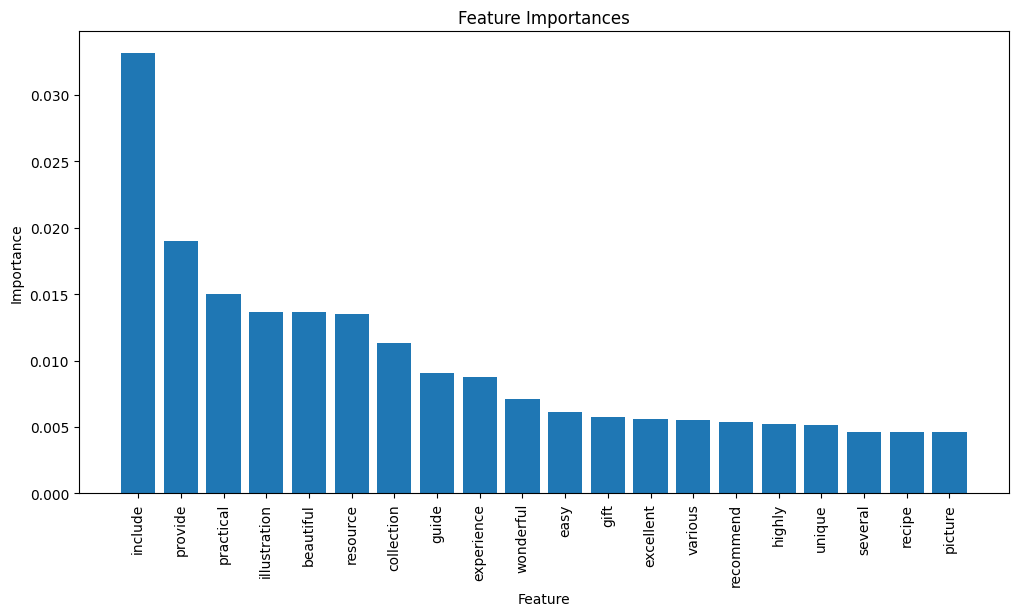

include: 0.03312738984823227
provide: 0.019019974395632744
practical: 0.01505226455628872
illustration: 0.013651384972035885
beautiful: 0.013625402003526688
resource: 0.013477012515068054
collection: 0.01135927252471447
guide: 0.009069915860891342
experience: 0.008749568834900856
wonderful: 0.0070908027701079845
easy: 0.006121054757386446
gift: 0.0057207378558814526
excellent: 0.005635307170450687
various: 0.0055249822326004505
recommend: 0.005412524100393057
highly: 0.0052198017947375774
unique: 0.0051882388070225716
several: 0.004664684645831585
recipe: 0.0046117473393678665
picture: 0.004594929050654173


In [22]:
# Extract feature importance
importance = xgb_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Sort feature importances in descending order
indices = np.argsort(importance)[::-1]
top_n = 20  # Number of top features to display

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(top_n), importance[indices[:top_n]], align='center')
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

# Print top features and their importance scores
top_features = [(feature_names[i], importance[i]) for i in indices[:top_n]]
for feature, score in top_features:
    print(f"{feature}: {score}")

Anchor: Analyze why both of these feature importances look different

light gbm feature importance makes a lot more sense. Can I consider this a facture when choosing the best model or should I consider the scores alone?

**Light GBM Model:**

In [23]:
# Using LightGBM
lgb_model = lgb.LGBMRegressor()
# Fitting the model on train
lgb_model.fit(X_train_embs, y_train)
joblib.dump(lgb_model, 'lgb_model.pkl')

# Load model lgb
# lgb_model = joblib.load('lgb_model.pkl')

# Perform 5-fold cross-validation
lgb_cv_scores = cross_val_score(lgb_model, X_train_embs, y_train, cv=5, scoring='neg_root_mean_squared_error')
joblib.dump(lgb_cv_scores, 'lgb_cv_scores.pkl')

# Load CV scores
# lgb_cv_scores = joblib.load('lgb_cv_scores.pkl')

# Convert negative RMSE to positive
cv_rmse = -lgb_cv_scores

print(f"Cross-Validated RMSE: {cv_rmse}")
print(f"Mean RMSE: {cv_rmse.mean()}")
print(f"Standard Deviation of RMSE: {cv_rmse.std()}")

lgb_predictions = lgb_model.predict(X_val_embs)
print(f"LightGBM RMSE: {mean_squared_error(y_val, lgb_predictions, squared=False)}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 77.177240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039916
[LightGBM] [Info] Number of data points in the train set: 872200, number of used features: 5000
[LightGBM] [Info] Start training from score 0.548281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 81.126333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039228
[LightGBM] [Info] Number of data points in the train set: 697760, number of used features: 5000
[LightGBM] [Info] Start training from score 0.548303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 55.303758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

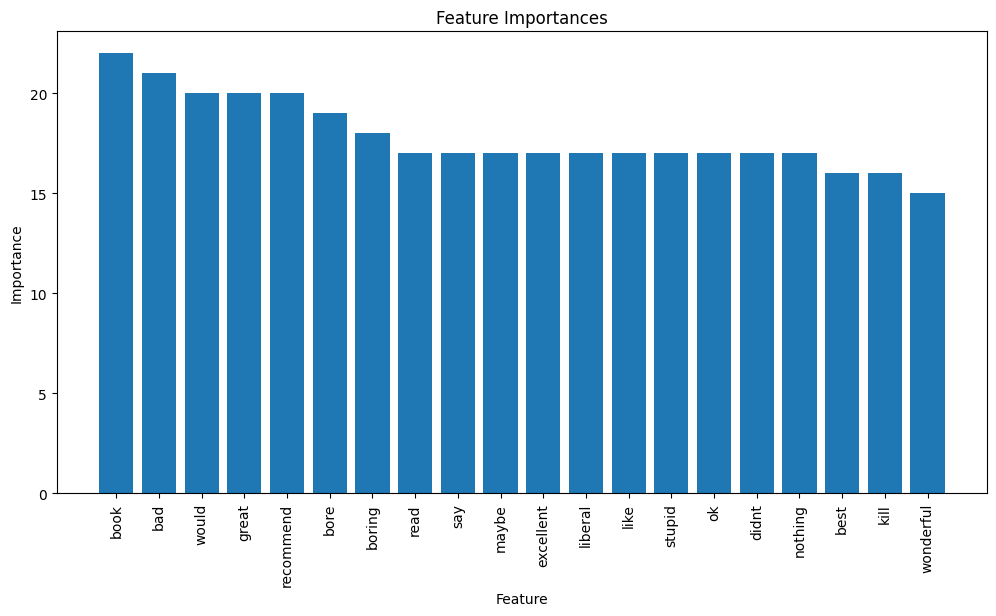

book: 22
bad: 21
would: 20
great: 20
recommend: 20
bore: 19
boring: 18
read: 17
say: 17
maybe: 17
excellent: 17
liberal: 17
like: 17
stupid: 17
ok: 17
didnt: 17
nothing: 17
best: 16
kill: 16
wonderful: 15


In [24]:
# Extract feature importance
importance = lgb_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Sort feature importances in descending order
indices = np.argsort(importance)[::-1]
top_n = 20  # Number of top features to display

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(top_n), importance[indices[:top_n]], align='center')
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

# Print top features and their importance scores
top_features = [(feature_names[i], importance[i]) for i in indices[:top_n]]
for feature, score in top_features:
    print(f"{feature}: {score}")

In [25]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb
import lightgbm as lgb

# Define base models
base_models = [
    ('ridge', ridge_model),
    ('xgb', xgb_model),
    ('lgb', lgb_model)
]

# Define stacking model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=Ridge())

# Fit stacking model
stacking_model.fit(X_train_embs, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 73.777229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039916
[LightGBM] [Info] Number of data points in the train set: 872200, number of used features: 5000
[LightGBM] [Info] Start training from score 0.548281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 60.362850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1039228
[LightGBM] [Info] Number of data points in the train set: 697760, number of used features: 5000
[LightGBM] [Info] Start training from score 0.548303
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 60.367363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

NameError: name 'y_val_embs' is not defined

In [26]:
# Predict and evaluate
y_pred = stacking_model.predict(X_val_embs)
print("Stacking Model RMSE: ", mean_squared_error(y_val, y_pred, squared=False))


Stacking Model RMSE:  0.16555161998953496


In [27]:
joblib.dump(stacking_model, 'stacking_model.pkl')

['stacking_model.pkl']

## Sampling Techniques

## Hyperparameter Tuning

## Conclusion

## Brainstorming/Improvements